# Data-driven computational mechanics solver for truss structures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ddtruss import Truss, DataDrivenSolver

params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14,
          "savefig.bbox": "tight"}
plt.rcParams.update(params)

%matplotlib inline

# 1-d examples

Consider a single bar composed of two node points $A=(0, 0)$ and $B=(1, 0)$. The left point is fixed and we prescribe to the bar either a
- a soft device, by applying a force $F_x=1$ on $B$ and fixing $u_y=0$ on $B$
- a hard device, by applying $u=U=(1, 0)$ for $B$.

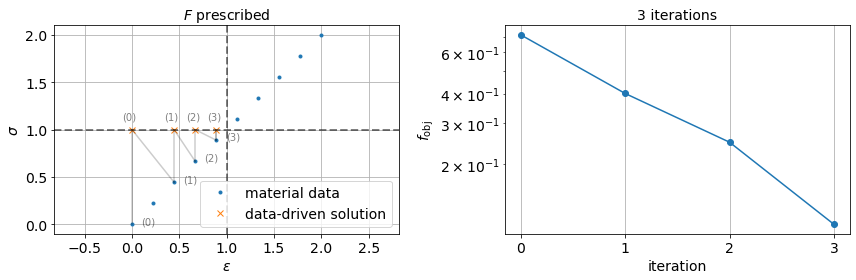

In [51]:
# Truss definition
points = np.array([
    [0, 0],
    [1, 0],
])

lines = np.array([
    [0, 1],
], dtype=int)
truss = Truss(points, lines)

device = "soft"
if device == "soft":
    U_dict = {0: [0, 0], 1: [None, 0]}
    F_dict = {1: [1, 0]}
else:
    U_dict = {0: [0, 0], 1: [1, 0]}
    F_dict = {}

# Find the reference solution corresponding to E = 1
E = 1
u, eps_ref, sig_ref = truss.solve(E=E, U_dict=U_dict, F_dict=F_dict)

# Define the data-driven solver
ddsolver = DataDrivenSolver(truss)

# Generate and load a sample material data set
eps_data = np.linspace(0, 2, 10)
sig_data = E * eps_data
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

# Solve the data-driven problem
u, *_, iter_history = ddsolver.solve(
    U_dict=U_dict,
    F_dict=F_dict,
    idx=[0],
    n_neighbors=1,
    save_history=True,
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(material_data[:, 0], material_data[:, 1], "C0.", label="material data")

eps, sig, idx = iter_history["eps"][:, 0], iter_history["sig"][:, 0], iter_history["idx"][:, 0]

plt.plot(eps, sig, "C1x", label="data-driven solution")
eps_sig = material_data[idx]
for i in range(len(eps)):
    plt.plot([eps_sig[i, 0], eps[i]], [eps_sig[i, 1], sig[i]], "k-", alpha=0.2)
    plt.plot([eps[i], eps_sig[i + 1, 0]], [sig[i], eps_sig[i + 1, 1]], "k-", alpha=0.2)
    if device == "hard":
        plt.text(eps[i] + 0.1, sig[i], f"({i})", alpha=0.5)
        plt.text(eps_sig[i, 0] - 0.2, eps_sig[i, 1], f"({i})", alpha=0.5)
    else:
        plt.text(eps[i] - 0.1, sig[i] + 0.1, f"({i})", alpha=0.5)
        plt.text(eps_sig[i, 0] + 0.1, eps_sig[i, 1], f"({i})", alpha=0.5)

# plt.plot(eps_ref, sig_ref, "k*", markersize=12, label="true")
plt.axhline(1, color="k", linestyle="--", linewidth=2, alpha=0.5)
plt.axvline(1, color="k", linestyle="--", linewidth=2, alpha=0.5)
    
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\sigma$")
if device == "soft":
    plt.title("$F$ prescribed")
else:
    plt.title("$U$ prescribed")
plt.grid()
plt.axis("equal")
if device == "hard":
    loc = "upper left"
else:
    loc = "lower right"
plt.legend(loc=loc)
plt.subplot(1, 2, 2)
plt.semilogy(iter_history["f_obj"], "-o")
plt.xticks(np.arange(len(iter_history["f_obj"])))
plt.xlabel("iteration")
plt.ylabel("$f_\mathrm{obj}$")
plt.grid()
plt.title(f"{len(iter_history['f_obj']) - 1:d} iterations")

plt.tight_layout()

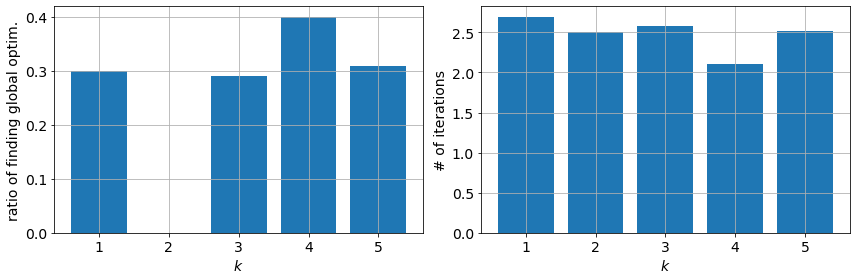

In [3]:
n_neighbors = [1, 2, 3, 4, 5]
n_global_optimal_found = np.zeros(len(n_neighbors))
n_iterations = np.zeros(len(n_neighbors))
n_runs = 100
for i in range(len(n_neighbors)):
    for _ in range(n_runs):
        *_, iter_history = ddsolver.solve(U_dict=U_dict, F_dict=F_dict, n_neighbors=n_neighbors[i])
        n_iterations[i] += len(iter_history["f_obj"])
        if iter_history["idx"][-1, 0] == 7:
            n_global_optimal_found[i] += 1
n_iterations /= 100

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(n_neighbors, n_global_optimal_found / n_runs)
plt.xlabel("$k$")
plt.ylabel("ratio of finding global optim.")
plt.grid()

plt.subplot(1, 2, 2)
plt.bar(n_neighbors, n_iterations)
plt.xlabel("$k$")
plt.ylabel("# of iterations")
plt.grid()
plt.tight_layout()

## 2-d problem

In [2]:
def plot(eps, sig, ddsolver, iter_history):
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    truss.plot(ax=ax[0], u=u, eps=eps)
    
    if ddsolver is not None:
        idx, *_ = ddsolver._nearest_material_points(np.hstack([eps.reshape((-1, 1)), sig.reshape((-1, 1))]))
        eps_sig_ = material_data[idx]
        ax[1].plot(material_data[:, 0], material_data[:, 1], "C0.", label="material data")
        for i in range(len(eps)):
            ax[1].plot([eps[i], eps_sig_[i, 0]], [sig[i], eps_sig_[i, 1]], "k-", alpha=0.5)
    
    ax[1].plot(eps, sig, "C1x", label="data-driven solution")
    
    ax[1].set_xlabel(r"$\varepsilon$")
    ax[1].set_ylabel(r"$\sigma$")
    ax[1].grid()
    ax[1].legend()
    
    ax[2].semilogy(iter_history["f_obj"], "-o")
    ax[2].set_xlabel("iteration")
    ax[2].set_ylabel("$f_\mathrm{obj}$")
    ax[2].grid()
    ax[2].set_title(f"{len(iter_history['f_obj']) - 1:d} iterations")
    
    fig.tight_layout()
    return fig, ax

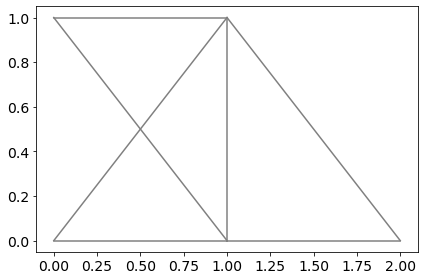

In [3]:
points = np.array([
    [0, 0],
    [1, 0],
    [2, 0],
    [1, 1],
    [0, 1],
])
lines = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [1, 3],
    [1, 4],
    [3, 4],
    [0, 3],
], dtype=int)

truss = Truss(points, lines)
truss.plot(line_style="-")
plt.tight_layout()

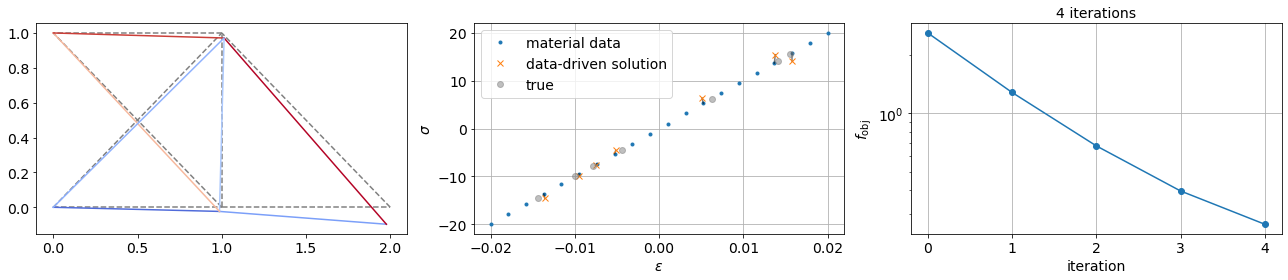

In [6]:
E = 1e3
U_dict = {0: [0, 0], 4: [0, 0]}
F_dict = {2: [0, -10]}

u, eps_ref, sig_ref = truss.solve(E=E, U_dict=U_dict, F_dict=F_dict)

ddsolver = DataDrivenSolver(truss)

eps_data = np.linspace(-0.02, 0.02, 20)
sig_data = E * eps_data
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, iter_history = ddsolver.solve(U_dict=U_dict, F_dict=F_dict, n_neighbors=1)
fig, ax = plot(eps, sig, ddsolver, iter_history)
ax[1].plot(eps_ref, sig_ref, "o", color="gray", label="true", alpha=0.5)
ax[1].legend()
fig.tight_layout()

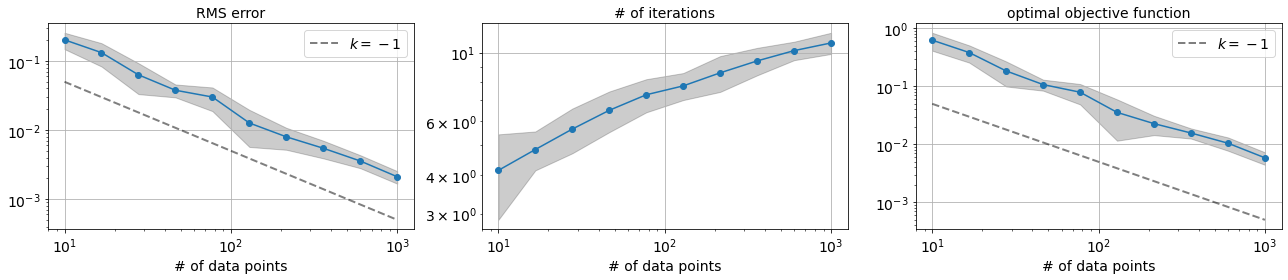

In [19]:
def rms_error(ref, curr):
    return np.sqrt(truss.integrate((ref - curr)**2) / truss.integrate(ref**2))

n_runs = 20
n_data = np.logspace(1, 3, 10)
error_eps = np.zeros((n_runs, len(n_data)))
n_iterations = np.zeros((n_runs, len(n_data)))
f_obj = np.zeros((n_runs, len(n_data)))

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

for i_run in range(n_runs):
    for i_data in range(len(n_data)):
        eps_data = np.linspace(-0.02, 0.02, int(n_data[i_data]))
        sig_data = E * eps_data
        material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
        ddsolver.load_material_data(material_data)
        u, eps, sig, iter_history = ddsolver.solve(U_dict=U_dict, F_dict=F_dict, n_neighbors=1)
        error_eps[i_run, i_data] = rms_error(eps_ref, eps)
        n_iterations[i_run, i_data] = len(iter_history["f_obj"])
        f_obj[i_run, i_data] = iter_history["f_obj"][-1]

def subplot(ax, data, title):
    mean = data.mean(axis=0)
    ax.loglog(n_data, mean, "-o")
    std = data.std(axis=0)
    ax.fill_between(n_data, mean - 1.96 * std, mean + 1.96 * std, color="k", alpha=0.2)
    ax.set_xlabel("# of data points")
    ax.set_title(title)
    ax.grid()

subplot(ax[0], error_eps, "RMS error")
ax[0].loglog(n_data, 0.5 / n_data, "k--", linewidth=2, alpha=0.5, label="$k=-1$")
ax[0].legend()

subplot(ax[1], n_iterations, "# of iterations")
subplot(ax[2], f_obj, "optimal objective function")
ax[2].loglog(n_data, 0.5 / n_data, "k--", linewidth=2, alpha=0.5, label="$k=-1$")
ax[2].legend()

fig.tight_layout()

# Noisy data

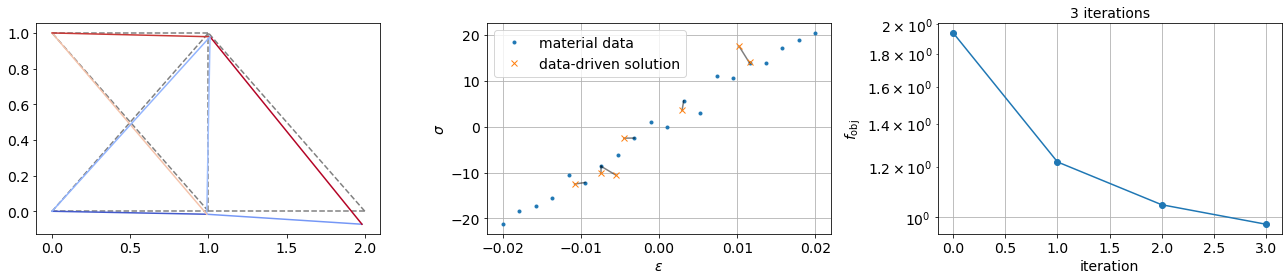

In [18]:
n_data = 20
eps_data = np.linspace(-0.02, 0.02, n_data)
sig_data = E * (eps_data + 0.08 * eps_data.max() * np.random.randn(n_data))
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, iter_history = ddsolver.solve(U_dict=U_dict, F_dict=F_dict, n_neighbors=4)
plot(eps, sig, ddsolver, iter_history);

# Nonlinear behavior

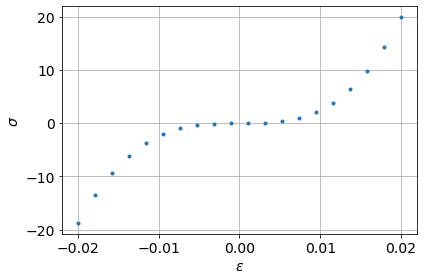

In [19]:
n_data = 20
eps_data = np.linspace(-0.02, 0.02, n_data)
A = 20 / (np.exp(0.02) - 1)**3
sig_data = A * (np.exp(eps_data) - 1)**3
plt.plot(eps_data, sig_data, ".")
plt.grid()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\sigma$")
plt.tight_layout()

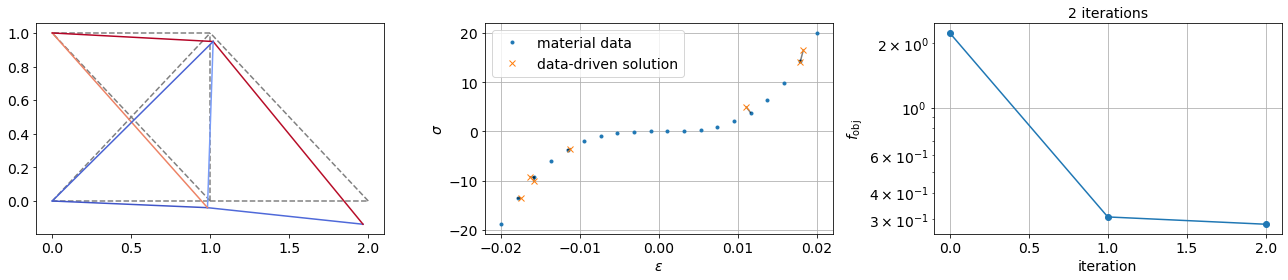

In [20]:
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, iter_history = ddsolver.solve(U_dict=U_dict, F_dict=F_dict, n_neighbors=1)
plot(eps, sig, ddsolver, iter_history);